In [1]:
sources = {
	"ENCSR310RJN":{
	"url_pval":"https://www.encodeproject.org/files/ENCFF475OGW/@@download/ENCFF475OGW.bigWig",
	"url_fc":"https://www.encodeproject.org/files/ENCFF875SZE/@@download/ENCFF875SZE.bigWig",
	"description":"Homo sapiens heart left ventricle tissue male adult (43 years)"
},
"ENCSR913OWV":{
	"url_pval":"https://www.encodeproject.org/files/ENCFF082JVW/@@download/ENCFF082JVW.bigWig",
	"url_fc":"https://www.encodeproject.org/files/ENCFF347SHR/@@download/ENCFF347SHR.bigWig",
	"description":"Homo sapiens from a donor with amyotrophic lateral sclerosis; motor neuron"
},
"ENCSR607BTF":{
	"url_pval":"https://www.encodeproject.org/files/ENCFF258LPU/@@download/ENCFF258LPU.bigWig",
	"url_fc":"https://www.encodeproject.org/files/ENCFF646EEM/@@download/ENCFF646EEM.bigWig",
	"description":"Homo sapiens right lobe of liver tissue male adult (45 years)"
},
"ENCSR338NEI":{
	"url_fc":"https://www.encodeproject.org/files/ENCFF330ZGD/@@download/ENCFF330ZGD.bigWig",
	"description":"Homo sapiens pancreas tissue female adult (41 years)"
},
"ENCSR436JNB":{
	"url_pval":"https://www.encodeproject.org/files/ENCFF218FQN/@@download/ENCFF218FQN.bigWig",
	"description":"H3K27ac ChIP-seq on spleen tissue female adult (61 years)"
},
"00fb8a3e09edc8c5dd05b99bc9f8e6e5.forward":{
	"url_fc":"00fb8a3e09edc8c5dd05b99bc9f8e6e5.forward.bw",
	"description":"CAGE sample 00fb8a3e09edc8c5dd05b99bc9f8e6e5"
},
"hg38.phastCons100way":{
	"url_fc":"data/bw/hg38.phastCons100way_fc.bw",
	"description":"PhastCons 100-way conservation scores"
},
"phastCons-43p":{
	"url_fc":"data/bw/phastCons-43p_fc.bigWig",
	"description":"PhastCons 43 primates conservation scores"
}
}

In [2]:
from Bio.Seq import Seq
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybedtools as pbt
dataset_path = "songlab/TraitGym"
# dataset_config = "mendelian_traits"
dataset_config = "complex_traits"
model_path = "songlab/gpn-animal-promoter"
# in the paper we average with the predictions with the reverse complement
# however for a quick evaluation you can omit this
average_rc = False
dataset = load_dataset(dataset_path, dataset_config, split="test")
V = dataset.to_pandas()
V1 = V.copy()
V1["chrom"] = V1["chrom"].apply(lambda x: "chr" + x)
V1["end"] = V1["pos"] + 1
V1

,chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,tss_dist,match_group,end
0,chr1,867476,C,T,0.001560,,False,0.079465,44.053,non_coding_transcript_exon_variant,56446,non_coding_transcript_exon_variant_0,867477
1,chr1,868052,T,C,0.001791,,False,0.077747,44.057,non_coding_transcript_exon_variant,55870,non_coding_transcript_exon_variant_0,868053
2,chr1,868635,A,G,0.004349,,False,0.075255,43.639,non_coding_transcript_exon_variant,55287,non_coding_transcript_exon_variant_0,868636
3,chr1,870176,T,A,0.000000,,False,0.084371,37.271,non_coding_transcript_exon_variant,53746,non_coding_transcript_exon_variant_0,870177
4,chr1,1052930,A,G,0.001467,,False,0.058385,46.907,non_coding_transcript_exon_variant,18823,non_coding_transcript_exon_variant_1,1052931
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11395,chr22,50368376,T,C,0.000000,,False,0.191810,86.507,dELS,3695,dELS_204,50368377
11396,chr22,50571623,C,T,0.000000,,False,0.061159,23.900,dELS,6291,dELS_202,50571624
11397,chr22,50671289,G,A,0.000000,,False,0.036223,12.733,pELS_flank,3125,pELS_flank_26,50671290
11398,chr22,50713837,C,G,0.000000,,False,0.060562,20.896,dELS,8340,dELS_202,50713838


In [3]:
import pyBigWig

def get_coverage(bw, chrom, start, end, r=50):
	# Calculate the extended region
	region_start = max(0, start - r)  # Ensure start is not negative
	region_end = end + r
	
	# Fetch coverage values
	# print (chrom, region_start, region_end)
	coverage = bw.stats(chrom, region_start, region_end, type="mean")
	assert len(coverage) == 1, "Coverage should be a single value"
	coverage = coverage[0]
	
	return coverage

def get_variant_coverage(variant, bw, r, offset=0):
	chrom = variant["chrom"]
	start = variant["pos"] + offset
	end = variant["end"] + offset
	coverage = get_coverage(bw, chrom, start, end, r)
	if coverage is None:
		coverage = 0
	return coverage


bw_name = "phastCons-43p_fc"
bw = pyBigWig.open(f"data/bw/{bw_name}.bigWig")
print(bw.chroms())
V1["test"] = V1.apply(lambda x: get_variant_coverage(x, bw, 100), axis=1)
bw.close()

{'chr1': 248956422, 'chr10': 133797422, 'chr11': 135086622, 'chr12': 133275309, 'chr13': 114364328, 'chr14': 107043718, 'chr15': 101991189, 'chr16': 90338345, 'chr17': 83257441, 'chr18': 80373285, 'chr19': 58617616, 'chr2': 242193529, 'chr20': 64444167, 'chr21': 46709983, 'chr22': 50818468, 'chr3': 198295559, 'chr4': 190214555, 'chr5': 181538259, 'chr6': 170805979, 'chr7': 159345973, 'chr8': 145138636, 'chr9': 138394717, 'chrX': 156040895, 'chrY': 57227415}


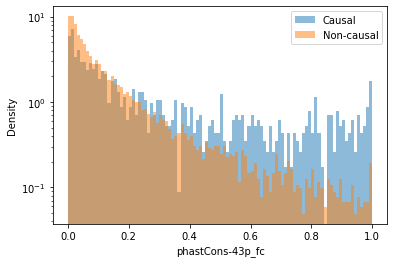

In [4]:
import matplotlib.pyplot as plt
plt.hist(V1.query("label == True")["test"], bins=100, density=True, label="Causal", alpha=0.5)
plt.hist(V1.query("label == False")["test"], bins=100, density=True, label="Non-causal", alpha=0.5)
plt.xlabel(bw_name)
plt.ylabel("Density")
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [5]:
preferred = "pval"
for s in sources:
	if s == "hg38.phastCons100way" or s == "phastCons-43p":
		r = 2
	else:
		r = 50
	if "url_" + preferred in sources[s]:
		field = preferred
	else:
		field = "fc" if "url_fc" in sources[s] else "pval" if "url_pval" in sources[s] else None
	if field is None:
		print(f"No {preferred} or fc url found for {s}")
		continue
	bw = pyBigWig.open(f"data/bw/{s}_{field}.bigWig")
	V1[f"{s}"] = V1.apply(lambda x: get_variant_coverage(x, bw, r), axis=1)
	bw.close()

In [6]:
import pandas as pd
adastra_all = pd.read_csv("adastra_all.tsv", sep="\t")
adastra_all["ASEdiff"] = abs(adastra_all["es_mean_ref"] - adastra_all["es_mean_alt"])
adastra_all[["comb_es","fdr_comb_pval", "ASE_best_allele_source"]] = adastra_all.apply(
	lambda x: pd.Series({"comb_es":x["es_mean_ref"], "fdr_comb_pval":x["fdrp_bh_ref"], "ASE_best_allele_source":"ref"}) \
		if x["fdrp_bh_ref"] < x["fdrp_bh_alt"] else \
			pd.Series({"comb_es":x["es_mean_alt"], "fdr_comb_pval":x["fdrp_bh_alt"], "ASE_best_allele_source":"alt"}), axis=1
)
field =  "fdr_comb_pval" #"comb_es" #"max_cover" #"fdr_comb_pval" #"comb_es"
higher_is_better = False
subset = adastra_all.\
	sort_values(by=["chr", "start", "end", "alt", field], ascending=[True, True, True, True, not higher_is_better]).\
	drop_duplicates(subset=["chr","start","end","alt"], keep="first")

if "fdr_comb_pval" in V1.columns:
	V1.drop(columns=["fdr_comb_pval"], inplace=True)
	
V1 = V1.merge(subset[["chrom", "pos", "end","ref", "alt",field]], 
					on=["chrom", "pos", "end","ref", "alt"], how="left")
V1["is_in_adastra"] = V1["fdr_comb_pval"].notna()
V1["fdr_comb_pval"] = V1["fdr_comb_pval"].fillna(1)

In [7]:
V1.groupby("label").apply(lambda x: x["is_in_adastra"].sum() / len(x))

label
False    0.587135
True     0.668421
dtype: float64

In [14]:
import pybedtools as pbd
constrain = pd.read_csv("data/gnomad.v4.1.constraint_metrics.tsv", sep="\t").query("transcript_type == 'protein_coding' and mane_select")
transcripts = pd.read_csv("data/ensemble_transcripts_mart_export.txt", sep="\t")
constrain = constrain.merge(transcripts, left_on=["transcript"], right_on=["Transcript stable ID"], how="left", validate="one_to_one").dropna(subset=["Transcription start site (TSS)"])
constrain.rename(columns={"Transcription start site (TSS)": "tss"}, inplace=True)
constrain = constrain.sort_values(by=["chromosome", "tss", "lof.oe_ci.upper"], ascending=True).drop_duplicates(subset=["chromosome", "tss"], keep="first")
constrain["end"] = constrain["tss"] + 1

constrain_bt = pbd.BedTool.from_dataframe(constrain[["chromosome", "tss", "end", "lof.oe_ci.upper"]]).sort()
# plof.oe - lower more damaging; we now recommend a threshold of LOEUF < 0.6
V1_bt = pbd.BedTool.from_dataframe(V1.reset_index()[["chrom", "pos", "end", "index"]]).sort()
closest = V1_bt.closest(constrain_bt).to_dataframe()
for col in ["tss", "lof.oe_ci.upper"]:
	if col in V1.columns:
		V1.drop(columns=[col], inplace=True)
closest = closest.rename(columns={"name": "index","thickEnd": "lof.oe_ci.upper", "strand": "tss"})[["index","lof.oe_ci.upper","tss"]]
V1 = V1.reset_index().merge(closest, left_on="index", right_on="index", how="left", validate="one_to_one").drop(columns=["index"])
# print (V1.head())
# print (V1.columns)
V1["tss_distance"] = abs(V1["pos"] - V1["tss"])
V1.loc[V1["lof.oe_ci.upper"]==".","lof.oe_ci.upper"] = 1.0
V1["lof.oe_ci.upper"] = V1["lof.oe_ci.upper"].astype(float)
V1["constraint_by_distance"] = V1.apply (lambda x: x["tss_distance"] * (1./(x["lof.oe_ci.upper"]+1e-3)), axis=1)

In [15]:
import pybedtools as pbd
constrain = pd.read_csv("data/gnomad.v4.1.constraint_metrics.tsv", sep="\t").query("transcript_type == 'protein_coding' and mane_select")
transcripts = pd.read_csv("data/ensemble_transcripts_mart_export.txt", sep="\t")
constrain = constrain.merge(transcripts, left_on=["transcript"], right_on=["Transcript stable ID"], how="left", validate="one_to_one").dropna(subset=["Transcription start site (TSS)"])
constrain.rename(columns={"Transcription start site (TSS)": "tss"}, inplace=True)
constrain = constrain.sort_values(by=["chromosome", "tss", "lof.oe_ci.upper"], ascending=True).drop_duplicates(subset=["chromosome", "tss"], keep="first")
constrain["end"] = constrain["tss"] + 1

constrain = constrain[constrain["lof.oe_ci.upper"] < 0.3] # select highly constrained genes

constrain_bt = pbd.BedTool.from_dataframe(constrain[["chromosome", "tss", "end", "lof.oe_ci.upper"]]).sort()
V1_bt = pbd.BedTool.from_dataframe(V1.reset_index()[["chrom", "pos", "end", "index"]]).sort()
closest = V1_bt.closest(constrain_bt).to_dataframe()
for col in ["highly_constrained_tss"]:
	if col in V1.columns:
		V1.drop(columns=[col], inplace=True)
closest = closest.rename(columns={"name": "index","strand": "highly_constrained_tss"})[["index","highly_constrained_tss"]]
V1 = V1.reset_index().merge(closest, left_on="index", right_on="index", how="left", validate="one_to_one").drop(columns=["index"])
# print (V1.head())
# print (V1.columns)
V1["highly_constrained_tss_distance"] = np.log10(abs(V1["pos"] - V1["highly_constrained_tss"]))
V1

,chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,...,hg38.phastCons100way,phastCons-43p,fdr_comb_pval,is_in_adastra,tss_distance,constraint_by_distance,highly_constrained_tss_distance,lof.oe_ci.upper,tss,highly_constrained_tss
0,chr1,867476,C,T,0.001560,,False,0.079465,44.053,non_coding_transcript_exon_variant,...,0.2332,0.0568,1.000000,False,56447,31981.303116,6.010135,1.764,923923,1891087
1,chr1,868052,T,C,0.001791,,False,0.077747,44.057,non_coding_transcript_exon_variant,...,0.7432,0.0008,1.000000,False,55871,31654.957507,6.009890,1.764,923923,1891087
2,chr1,868635,A,G,0.004349,,False,0.075255,43.639,non_coding_transcript_exon_variant,...,0.0962,0.0162,1.000000,False,55288,31324.645892,6.009643,1.764,923923,1891087
3,chr1,870176,T,A,0.000000,,False,0.084371,37.271,non_coding_transcript_exon_variant,...,0.0532,0.0022,0.144127,True,53747,30451.558074,6.008988,1.764,923923,1891087
4,chr1,1052930,A,G,0.001467,,False,0.058385,46.907,non_coding_transcript_exon_variant,...,0.0010,0.0024,1.000000,False,21376,11875.555556,5.923325,1.799,1074306,1891087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11395,chr22,50368376,T,C,0.000000,,False,0.191810,86.507,dELS,...,0.0084,0.0096,0.217421,True,25049,30547.560976,6.908363,0.819,50343327,42270653
11396,chr22,50571623,C,T,0.000000,,False,0.061159,23.900,dELS,...,0.0000,0.0136,1.000000,True,6804,9157.469717,6.919129,0.742,50578427,42270653
11397,chr22,50671289,G,A,0.000000,,False,0.036223,12.733,pELS_flank,...,0.0002,0.0070,1.000000,False,43137,36964.010283,6.924312,1.166,50628152,42270653
11398,chr22,50713837,C,G,0.000000,,False,0.060562,20.896,dELS,...,0.0000,0.0022,1.000000,False,24367,25812.500000,6.926506,0.943,50738204,42270653


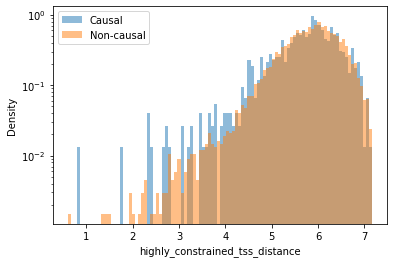

In [16]:
import matplotlib.pyplot as plt
fname = "highly_constrained_tss_distance"
bins = np.histogram_bin_edges(V1[fname], bins=100)
plt.hist(V1.query("label == True")[fname], bins=bins, density=True, label="Causal", alpha=0.5)
plt.hist(V1.query("label == False")[fname], bins=bins, density=True, label="Non-causal", alpha=0.5)
plt.xlabel(fname)
plt.ylabel("Density")
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

/home/vsfishman/miniconda3/envs/horovod/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression AUPRC: 0.2518


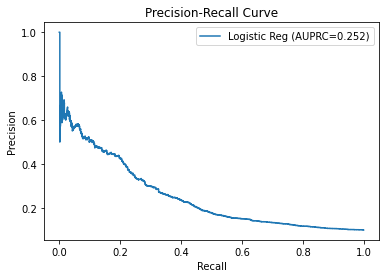

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score

# Prepare data
# X = V1[['ENCSR310RJN_fc', 'ENCSR913OWV_fc', 'ENCSR607BTF_fc']].values
keys = list(sources.keys())
extra_keys = ["is_in_adastra", "fdr_comb_pval"]
X = V1[keys + extra_keys].values
y = V1['label'].astype(int).values  # Ensure label is 0/1

# Logistic Regression (recommended for classification)
logreg = LogisticRegression()
logreg.fit(X, y)
y_pred_log = logreg.predict_proba(X)[:, 1]

# For logistic regression predictions
precision_log, recall_log, _ = precision_recall_curve(y, y_pred_log)
auprc_log = average_precision_score(y, y_pred_log)

print(f"Logistic Regression AUPRC: {auprc_log:.4f}")

import matplotlib.pyplot as plt

plt.plot(recall_log, precision_log, label=f'Logistic Reg (AUPRC={auprc_log:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import average_precision_score
import numpy as np
import pandas as pd
from tqdm import tqdm

def train_logistic_regression(X, y, groups):
	pipeline = Pipeline([
		('imputer', SimpleImputer(
			missing_values=np.nan, strategy='mean'
		)),
		('scaler', StandardScaler()),
		('linear', LogisticRegression(
			class_weight="balanced",
			random_state=42,
		))
	])
	Cs = np.logspace(-8, 0, 10)
	param_grid = {
		'linear__C': Cs,
	}
	clf = GridSearchCV(
		pipeline,
		param_grid,
		scoring="average_precision",
		cv=GroupKFold(),
		n_jobs=-1,
	)
	clf.fit(X, y, groups=groups)
	# print(f"{clf.best_params_=}")
	linear = clf.best_estimator_.named_steps["linear"]
	coef = pd.DataFrame({
		"feature": X.columns,
		"coef": linear.coef_[0],
	}).sort_values("coef", ascending=False, key=abs)
	return clf

def predict(clf, X):
	return clf.predict_proba(X)[:, 1]

def train_predict(V_train, V_test, features, train_f):
	clf = train_f(V_train[features], V_train.label, V_train.chrom)
	return predict(clf, V_test[features])

keys = list(sources.keys())
extra_keys = ["is_in_adastra", "fdr_comb_pval"]
all_features = keys + extra_keys

mask_train_list = []
classifier_map = {
	"LogisticRegression": train_logistic_regression,
}

for chrom in V1.chrom.unique():
	mask_train = V1.chrom != chrom
	mask_train_list.append(mask_train)

epigenetics_features = ['ENCSR310RJN', 'ENCSR913OWV', 'ENCSR607BTF', 'ENCSR338NEI', 'ENCSR436JNB', '00fb8a3e09edc8c5dd05b99bc9f8e6e5.forward']
conservation_features = ['phastCons-43p']
adastra_features = ['is_in_adastra', 'fdr_comb_pval']
constraint_features = ['constraint_by_distance', 'lof.oe_ci.upper', 'tss_distance', 'highly_constrained_tss_distance']
feature_sets = {
	"all": epigenetics_features + conservation_features + adastra_features + constraint_features,
	"epigenetics": epigenetics_features,
	"conservation": conservation_features,
	"adastra": adastra_features,
	"constraint": constraint_features,
	"all_but_adastra": epigenetics_features + conservation_features + constraint_features,
	"all_but_epigenetics": conservation_features + adastra_features + constraint_features,
	"all_but_conservation": epigenetics_features + adastra_features + constraint_features,
	"all_but_constraint": epigenetics_features + adastra_features + conservation_features,
}

results = {}

for feature_set in tqdm(feature_sets):
	s = 0
	all_features = feature_sets[feature_set]
	for mask_train in mask_train_list:
				mask_test = ~mask_train
				V1.loc[mask_test, "score"] = train_predict(
					V1[mask_train], V1[mask_test], all_features,
					classifier_map["LogisticRegression"]
				)
				s += average_precision_score(V1.loc[mask_test,"label"], V1.loc[mask_test,"score"])*mask_test.sum()
	s /= V1.shape[0]
	results[feature_set] = s
	print (f"{feature_set}: {s}")

results

  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:11<01:30, 11.34s/it]

all: 0.258295194930558


 22%|██▏       | 2/9 [00:18<01:00,  8.69s/it]

epigenetics: 0.16861242538253074


 33%|███▎      | 3/9 [00:23<00:42,  7.08s/it]

conservation: 0.24385502883832785


/home/vsfishman/miniconda3/envs/horovod/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 44%|████▍     | 4/9 [00:28<00:32,  6.52s/it]

adastra: 0.15265716849741906


/home/vsfishman/miniconda3/envs/horovod/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vsfishman/miniconda3/envs/horovod/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

constraint: 0.13989975767933602


 67%|██████▋   | 6/9 [00:42<00:20,  6.87s/it]

all_but_adastra: 0.25466004593865676


 78%|███████▊  | 7/9 [00:50<00:14,  7.10s/it]

all_but_epigenetics: 0.24637675590418515


 89%|████████▉ | 8/9 [00:59<00:07,  7.82s/it]

all_but_conservation: 0.17669667213080392


100%|██████████| 9/9 [01:07<00:00,  7.55s/it]

all_but_constraint: 0.25438288929052205


{'all': 0.258295194930558,
 'epigenetics': 0.16861242538253074,
 'conservation': 0.24385502883832785,
 'adastra': 0.15265716849741906,
 'constraint': 0.13989975767933602,
 'all_but_adastra': 0.25466004593865676,
 'all_but_epigenetics': 0.24637675590418515,
 'all_but_conservation': 0.17669667213080392,
 'all_but_constraint': 0.25438288929052205}

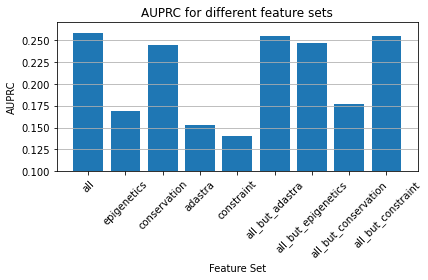

In [18]:
# plot bar: feature set vs auprc
import matplotlib.pyplot as plt

plt.bar(results.keys(), results.values())
plt.xticks(rotation=45)
plt.xlabel("Feature Set")
plt.ylabel("AUPRC")
plt.title("AUPRC for different feature sets")
plt.ylim(0.1, 0.27)
plt.grid(axis="y")
plt.tight_layout()
plt.show()